In [13]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import sys

# sys.path.append('..')
import src.data_processing.tfrecords as tfr

In [14]:
root = Path.cwd().parent
data = root / 'data'
tfrec = data / 'tfrec'

In [15]:
df = pd.read_csv(data / 'train.csv')

In [16]:
df.value_counts(['height', 'width']).head(10)

height  width
500     375      33150
375     500      25808
333     500       6194
500     281       4036
281     500       3142
500     500       2595
600     800       2433
800     600       1744
500     333       1004
334     500        927
Name: count, dtype: int64

In [17]:
df.isna().sum()

name                        0
family                     75
phylum                      0
order                      22
genus                       0
class                       0
file_name                   0
height                      0
width                       0
location_uncertainty    20864
date                        0
latitude                    0
longitude                   0
set                         0
dataset                     0
specific_epithet            0
image_dir_name              0
common_name              7827
file_path                   0
gcs_path                    0
class_id                    0
class_priors                0
norm_date                   0
dtype: int64

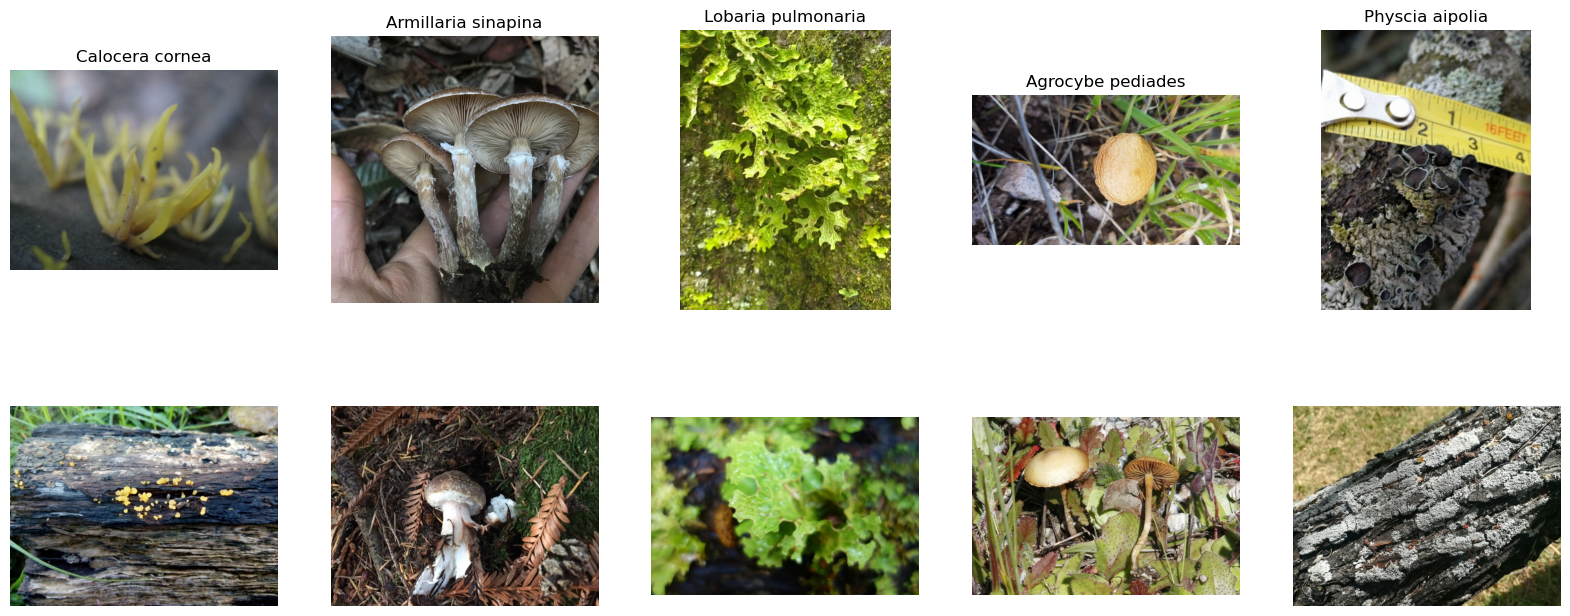

In [19]:
plt.figure(figsize=(20, 8))
classes = df['name'].sort_values().sample(5)
for i, cls in enumerate(classes, start=1):
    imgs = df[df['name'] == cls].sample(2)['file_path']
    for j, img in enumerate(imgs):
        im = cv2.imread('../' + str(img)e)
        im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        plt.subplot(2, 5, i + (j * 5))
        if j == 0:
            plt.gca().set_title(cls)
        plt.axis('off')
        plt.imshow(im)

In [18]:
val = df[df['set'] == 'val'].sample(frac=1, random_state=42).reset_index(drop=True)
train = df[df['set'] == 'train'].sample(frac=1, random_state=42).reset_index(drop=True)

In [19]:
num_train_records = 107
num_val_records = 5
TRAIN_IMGS = train['file_path'].to_list()
VAL_IMGS = val['file_path'].to_list()
TRAIN_SIZE = len(TRAIN_IMGS) // num_train_records
VAL_SIZE = len(VAL_IMGS) // num_val_records
CT = len(TRAIN_IMGS) // TRAIN_SIZE + int(len(TRAIN_IMGS) % TRAIN_SIZE != 0)
CT2 = len(VAL_IMGS) // VAL_SIZE + int(len(VAL_IMGS) % VAL_SIZE != 0)

In [22]:
tfr.write_records(train, CT, TRAIN_SIZE, TRAIN_IMGS, 'train', data)
tfr.write_records(val, CT2, VAL_SIZE, VAL_IMGS, 'val', data)


Writing TFRecord 0 of 108...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 
Writing TFRecord 1 of 108...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 
Writing TFRecord 2 of 108...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 
Writing TFRecord 3 of 108...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 
Writing TFRecord 4 of 108...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 
Writing TFRecord 5 of 108...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 
Writing TFRecord 6 of 108...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 
Writing TFRecord 7 of 108...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 
Writing TFRecord 8 of 108...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 
Writing TFRecord 9 of 108...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 
Writing TFRecord 10 of 108...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 
Writing TFRecord 11 of 108...
